In [1]:
%pylab inline
from collections import OrderedDict
import os
import pandas as pd
from riboraptor.ribocode_utils import wilcoxon_greater, extract_frame,  test_frame
from riboraptor.coherence import coherence
import xlrd

from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns
sns.set_context('poster')
sns.set_style('whitegrid')

COH_CUTOFF = 0.428
PVAL_CUTOFF = 0.05
cbb_palette = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]


Populating the interactive namespace from numpy and matplotlib


In [2]:
def read_coverage_tsv(fp, read_lengths=None):
    try:
        df = pd.read_table(fp, header=None)
    except pd.errors.EmptyDataError:
        print('Empty {}'.format(fp))
        raise
        

    df.columns =  ['read_length', 'offset', 'coverage']
    coverages = OrderedDict()
    if read_lengths is None:
        read_lengths = sorted(df.read_length.unique())

    for read_length in read_lengths:
        try:
            df_subset = df[df.read_length==read_length].iloc[0]
        except IndexError:
            print ('IndexError: {} | fp: {} | read_length: {}'.format(df[df.read_length==read_length], fp, read_length))
            raise

        coverage = eval(df_subset.coverage)
        coverage = pd.Series(coverage, index=np.arange(-df_subset.offset, len(coverage)-df_subset.offset))
        coverages[read_length]  = coverage
    return coverages

def get_coherence_and_wilcox_results(coverage):
    coh = coherence(coverage)
    
    

In [3]:
assembly_common_name_map = {'mm10': 'mouse', 'hg38': 'human'}

sheet_name = 'mm10'
excel_df = pd.read_excel('../data/datasets_info.xlsx', sheet_name=sheet_name)
root_dir = '/staging/as/wenzhenl/re-ribo-analysis/'

In [4]:
excel_df

,GEO,SRA,RIBO sample,RNA sample,read lengths,offsets,RIBO adapter,RNA adapter,RIBO strandedness,RNA strandedness
0,GSE22001,SRP003554,SRX026871,SRX026872,"28,29,30","12,12,12",TCGTATG,TCGTATG,forward,forward
1,GSE72064,SRP062407,SRX1149649,SRX1149668,"28,29,30,31","12,12,12,12",TGGAATTCTCGGGTGCCAAGG,TGGAATTCTCGGGTGCCAAGG,forward,forward
2,GSE84112,SRP078005,SRX1900396,SRX1900402,"26,27,28,29,30","12,12,12,12,12",TGGAATTCTCGGGTGCCAAGG,TGGAATTCTCGGGTGCCAAGG,forward,forward
3,GSE89011,SRP091889,SRX2255510,SRX2255511,"26,27,28,29,30","12,12,12,12,12",AGATCGGAAGAGCACACGTCT,AGATCGGAAGAGCACACGTCT,forward,forward
4,GSE102890,SRP115915,SRX3110803,SRX3110807,"29,30,31,32,33,34","12,12,12,13,13,13",TGGAATTCTCGGGTGCCAAGG,TGGAATTCTCGGGTGCCAAGG,forward,forward
5,GSE99787,SRP108787,SRX2893684,SRX2893692,"25,26,27,28","12,10,11,12",None,None,forward,reverse


In [5]:
runtable_file = './results/{}_datasets_runtable.xlsx'.format(assembly_common_name_map[sheet_name])
data = []
for srp in excel_df.SRA:
    try:
        runtable = pd.read_excel(runtable_file, sheet_name=srp)   
    except xlrd.XLRDError:
        print('Skipping {}'.format(srp))
        continue
        #raise
        
        
    #ribo_samples = runtable[runtable.assay == 'ribo']
    rna_samples = runtable[runtable.assay == 'rna']        
    for rna_srx in rna_samples.experiment_accession:
        rna_tsv_fp = os.path.join(root_dir,
                                  '{}_{}'.format(srp, assembly_common_name_map[sheet_name]), 
                                  'mapped', 
                                  'orfs', 
                                  '{}_metagene_profiles_5p.tsv'.format(rna_srx))
        try:
            rna_coverages = read_coverage_tsv(rna_tsv_fp)
        except pd.errors.EmptyDataError:
            continue
        rna_coherences = OrderedDict()
        rna_pvals = OrderedDict()
    
        for read_length in rna_coverages.keys():
            rna_coverages[read_length] = np.array(rna_coverages[read_length].values)
            coh = coherence(rna_coverages[read_length])[0]
            rna_coherences[read_length] = coh
            pval = test_frame(*extract_frame(rna_coverages[read_length]))[2]
            pval = test_frame(*extract_frame(rna_coverages[read_length]))[2]
            rna_pvals[read_length] = pval

            ribocop_prediction = 'rna'
            ribocode_prediction = 'rna'

            if coh > COH_CUTOFF:
                ribocop_prediction = 'ribo'

            if pval < PVAL_CUTOFF:
                ribocode_prediction = 'ribo'
            data.append((srp, rna_srx, 'rna', read_length, coh, ribocop_prediction, pval, ribocode_prediction))

Empty /staging/as/wenzhenl/re-ribo-analysis/SRP078005_mouse/mapped/orfs/SRX1900401_metagene_profiles_5p.tsv
Empty /staging/as/wenzhenl/re-ribo-analysis/SRP078005_mouse/mapped/orfs/SRX1900402_metagene_profiles_5p.tsv
Empty /staging/as/wenzhenl/re-ribo-analysis/SRP078005_mouse/mapped/orfs/SRX1900403_metagene_profiles_5p.tsv
Empty /staging/as/wenzhenl/re-ribo-analysis/SRP078005_mouse/mapped/orfs/SRX1900404_metagene_profiles_5p.tsv
Empty /staging/as/wenzhenl/re-ribo-analysis/SRP115915_mouse/mapped/orfs/SRX3110793_metagene_profiles_5p.tsv
Empty /staging/as/wenzhenl/re-ribo-analysis/SRP115915_mouse/mapped/orfs/SRX3110794_metagene_profiles_5p.tsv
Empty /staging/as/wenzhenl/re-ribo-analysis/SRP115915_mouse/mapped/orfs/SRX3110795_metagene_profiles_5p.tsv
Empty /staging/as/wenzhenl/re-ribo-analysis/SRP115915_mouse/mapped/orfs/SRX3110796_metagene_profiles_5p.tsv
Empty /staging/as/wenzhenl/re-ribo-analysis/SRP115915_mouse/mapped/orfs/SRX3110797_metagene_profiles_5p.tsv
Empty /staging/as/wenzhenl/r

In [6]:
summary_df = pd.DataFrame(data)
summary_df.columns = ['srp', 'srx', 'assay', 'read_length', 'ribocop_coherence', 'ribocop_prediction', 'ribocode_pval', 'ribocode_prediction']

In [7]:
summary_df.to_csv('./results/{}_ribocop_ribocode_summary_rna_only.tsv'.format(assembly_common_name_map[sheet_name]), header=True, index=False, sep='\t')

In [8]:
summary_df

,srp,srx,assay,read_length,ribocop_coherence,ribocop_prediction,ribocode_pval,ribocode_prediction
0,SRP003554,SRX026872,rna,20,0.028208,rna,9.734666e-01,rna
1,SRP003554,SRX026872,rna,21,0.101677,rna,1.000000e+00,rna
2,SRP003554,SRX026872,rna,22,0.069219,rna,9.345735e-01,rna
3,SRP003554,SRX026872,rna,23,0.078936,rna,1.287008e-04,ribo
4,SRP003554,SRX026872,rna,24,0.057988,rna,1.000000e+00,rna
5,SRP003554,SRX026872,rna,25,0.006498,rna,8.034926e-01,rna
6,SRP003554,SRX026872,rna,26,0.048621,rna,3.761380e-02,ribo
7,SRP003554,SRX026872,rna,27,0.108221,rna,1.000000e+00,rna
8,SRP003554,SRX026872,rna,28,0.019884,rna,5.037862e-01,rna
9,SRP003554,SRX026872,rna,29,0.029902,rna,1.927436e-02,ribo


In [9]:
barplot_data = []
for srp, group in summary_df.groupby('srp'):
    rna = group[group.assay=='rna']
    
    rna_total = rna.shape[0]
    
    group['label'] = 0
    group['ribocop_label'] = 0
    group['ribocode_label'] = 0
    
    group.loc[group['assay']=='ribo', 'label'] = 1
    group.loc[group['ribocop_prediction']=='ribo', 'ribocop_label'] = 1
    group.loc[group['ribocode_prediction']=='ribo', 'ribocode_label'] = 1
    
    ribocop_rna_as_rna = np.sum(rna['assay'] == rna['ribocop_prediction'])   
    ribocop_rna_as_ribo = rna_total - ribocop_rna_as_rna
    
    ribocode_rna_as_rna = np.sum(rna['assay'] == rna['ribocode_prediction'])   
    ribocode_rna_as_ribo = rna_total - ribocode_rna_as_rna
    
    barplot_data.append([srp, ribocop_rna_as_rna, 'ribocop_true_positives'])
    barplot_data.append([srp, ribocop_rna_as_ribo, 'ribocop_false_positives'])
    
    barplot_data.append([srp, ribocop_rna_as_rna/rna_total, 'ribocop_true_positives_normalized'])
    barplot_data.append([srp, ribocop_rna_as_ribo/rna_total, 'ribocop_false_positives_normalized'])
    
    
    barplot_data.append([srp, ribocode_rna_as_rna, 'ribocode_true_positives'])
    barplot_data.append([srp, ribocode_rna_as_ribo, 'ribocode_false_positives'])
    
    barplot_data.append([srp, ribocode_rna_as_rna/rna_total, 'ribocode_true_positives_normalized'])
    barplot_data.append([srp, ribocode_rna_as_ribo/rna_total, 'ribocode_false_positives_normalized'])
    
    
    
    
    
    
    
    

/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

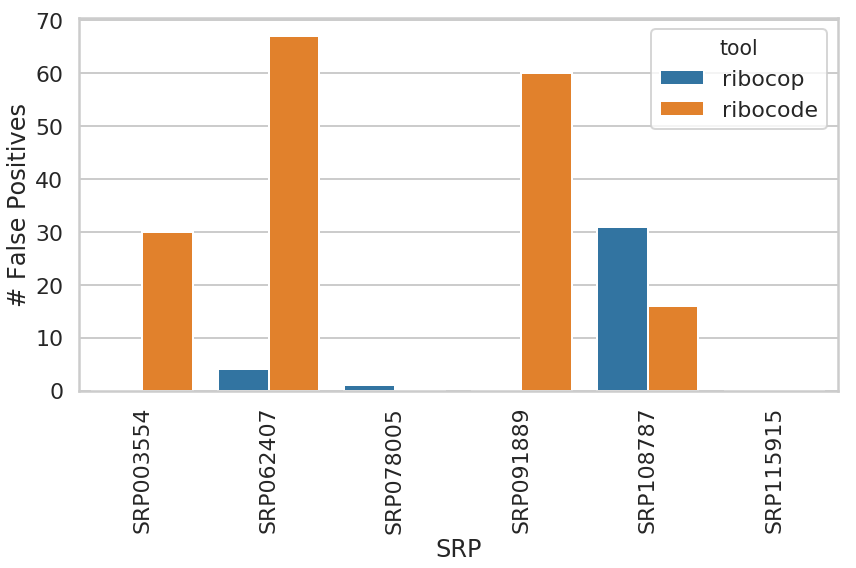

In [10]:
barplot_df = pd.DataFrame(barplot_data)
barplot_df.columns = ['SRP', 'value', 'tool']

barplot_df_fp = barplot_df[barplot_df.tool.isin(['ribocop_false_positives', 'ribocode_false_positives'])]
barplot_df_fp = barplot_df_fp.replace('ribocop_false_positives', 'ribocop').replace('ribocode_false_positives', 'ribocode')
barplot_df_fp = barplot_df_fp.rename(columns={'value': '# False Positives'})
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x='SRP', y='# False Positives', hue='tool', data=barplot_df_fp, ax=ax)
plt.xticks(rotation=90)
fig.tight_layout()
fig.savefig('./results/{}_ribocop_ribocode_metagene_fp.pdf'.format(assembly_common_name_map[sheet_name]), dpi='figure')

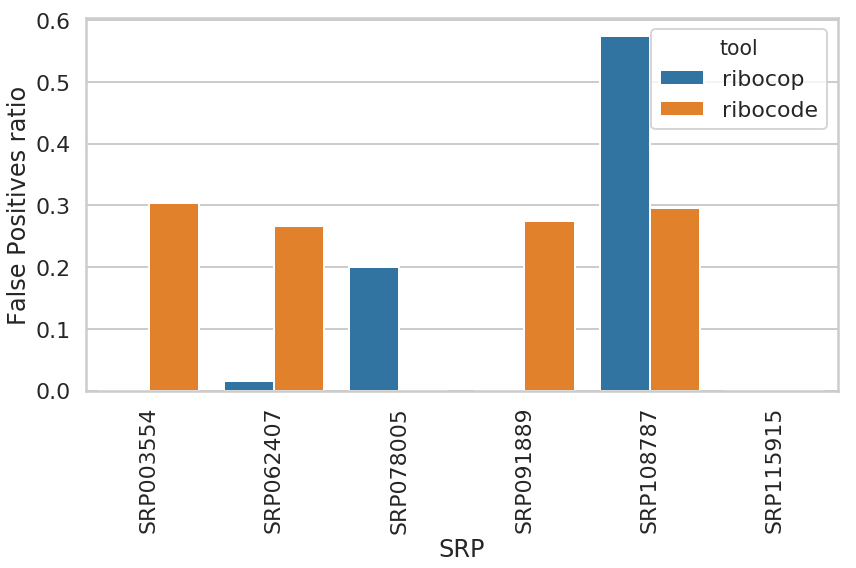

In [11]:
barplot_df = pd.DataFrame(barplot_data)
barplot_df.columns = ['SRP', 'value', 'tool']

barplot_df_fp = barplot_df[barplot_df.tool.isin(['ribocop_false_positives_normalized', 'ribocode_false_positives_normalized'])]
barplot_df_fp = barplot_df_fp.replace('ribocop_false_positives_normalized', 'ribocop').replace('ribocode_false_positives_normalized', 'ribocode')
barplot_df_fp = barplot_df_fp.rename(columns={'value': 'False Positives ratio'})
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x='SRP', y='False Positives ratio', hue='tool', data=barplot_df_fp, ax=ax)
plt.xticks(rotation=90)
fig.tight_layout()
fig.savefig('./results/{}_ribocop_ribocode_metagene_fp_normalized.pdf'.format(assembly_common_name_map[sheet_name]), dpi='figure')

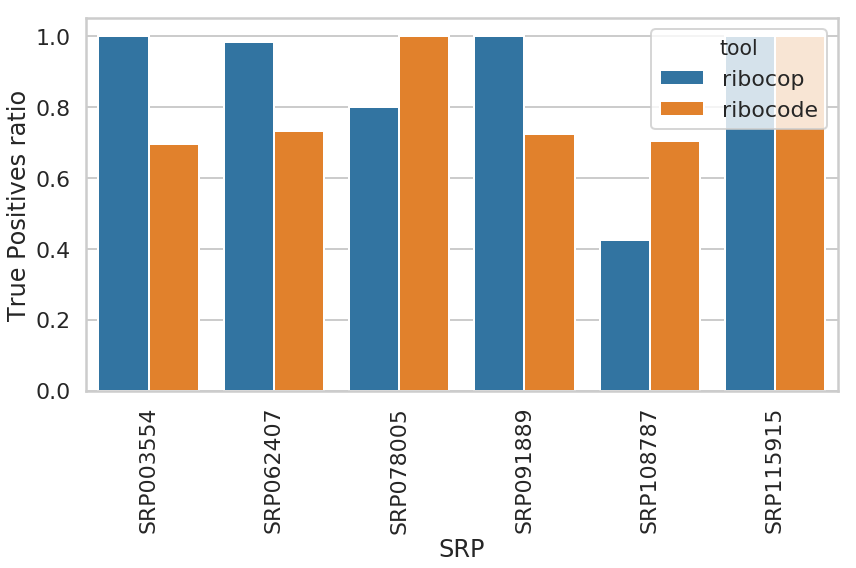

In [12]:
barplot_df = pd.DataFrame(barplot_data)
barplot_df.columns = ['SRP', 'value', 'tool']

barplot_df_fp = barplot_df[barplot_df.tool.isin(['ribocop_true_positives_normalized', 'ribocode_true_positives_normalized'])]
barplot_df_fp = barplot_df_fp.replace('ribocop_true_positives_normalized', 'ribocop').replace('ribocode_true_positives_normalized', 'ribocode')
barplot_df_fp = barplot_df_fp.rename(columns={'value': 'True Positives ratio'})
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x='SRP', y='True Positives ratio', hue='tool', data=barplot_df_fp, ax=ax)
plt.xticks(rotation=90)
fig.tight_layout()
fig.savefig('./results/{}_ribocop_ribocode_metagene_tp_normalized.pdf'.format(assembly_common_name_map[sheet_name]), dpi='figure')